# Imports

In [1]:
import os

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.signal import butter, lfilter
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report,
                             silhouette_score)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Create Dataframe

### **Preprocessing Functions**

In [85]:
def low_pass_filter(y, sr, cutoff=8000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return lfilter(b, a, y)


def preprocess_audio(y, sr, cutoff=8000, order=5):
    """
    Preprocesses a single audio signal.

    Parameters:
        y (np.ndarray): Audio signal.
        sr (int): Sampling rate.
        cutoff (int, optional): Cutoff frequency for low-pass filter. Default is 8000 Hz.
        order (int, optional): Order of the Butterworth filter. Default is 5.

    Returns:
        np.ndarray: Processed audio signal.
    """

    # Apply low-pass filter
    y_filtered = low_pass_filter(y, sr, cutoff, order)

    return y_filtered

In [86]:
def create_emotion_dataframe(data_path):
    """
    Creates a dataframe of file names, their corresponding emotion labels,
    reads and preprocesses audio data while traversing the folders,
    and displays a progress bar.

    Parameters:
        data_path (str): Path to the main directory containing emotion folders.

    Returns:
        pd.DataFrame: A DataFrame with columns - 'filename', 'emotion', 'audio_data', 'sr', 'processed_audio'.
    """
    # List to store file information
    data = []

    # Walk through each folder in the data directory with progress bar
    folders = [
        folder
        for folder in os.listdir(data_path)
        if os.path.isdir(os.path.join(data_path, folder))
    ]
    for folder in tqdm(folders, desc="Processing folders"):
        folder_path = os.path.join(data_path, folder)

        # Extract the emotion name from the folder name
        emotion = folder.split("_")[-1].lower()

        # List all .wav files in the folder
        files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]
        for file in files:
            file_path = os.path.join(folder_path, file)

            try:
                # Load the audio file and get its waveform and sample rate
                audio_data, sr = librosa.load(file_path, sr=None)

                # Preprocess the audio
                processed_audio = preprocess_audio(audio_data, sr)

                # Append filename, emotion, audio waveform data, sample rate, and processed audio to the list
                data.append((file, emotion, audio_data, sr, processed_audio))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(
        data, columns=["filename", "emotion", "audio_data", "sr", "processed_audio"]
    )
    return df

In [ ]:
data_path = "data"

original_df = create_emotion_dataframe(data_path)
original_df.head()

In [ ]:
# define number of unique emotions
n_emotions = original_df["emotion"].nunique()
n_emotions

## **Feature Extraction**

### Prosodic Features

#### Extract Pitch Feature

In [ ]:
def extractNplot_pitch(audio_file):
    """
    Extracts and visualizes the pitch (F0) of the audio signal.

    The function estimates the fundamental frequency (F0) using `librosa.pyin`. 
    It computes basic statistics (mean, standard deviation, min, and max) for the 
    cleaned pitch values (non-NaN). Additionally, it plots both the audio waveform 
    and the estimated pitch over time.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        None: This function does not return any values but visualizes the results 
        and prints the computed statistics.
    """
    # Estimate the pitch (F0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=300, sr=sr)

    # Remove NaN values (indicating pauses or unvoiced regions)
    f0_cleaned = f0[~np.isnan(f0)]

    # Statistics about the pitch
    pitch_mean = np.mean(f0_cleaned)
    pitch_std = np.std(f0_cleaned)
    pitch_min = np.min(f0_cleaned)
    pitch_max = np.max(f0_cleaned)

    print("Non-NaN F0 values:", f0_cleaned)
    print("Mean:", pitch_mean)
    print("Std:", pitch_std)
    print("Min:", pitch_min)
    print("Max:", pitch_max)

    # Generate time axis for the audio waveform
    time_audio = np.linspace(0, len(y) / sr, len(y))

    # Generate time axis for the estimated pitch (F0)
    time_pitch = np.linspace(0, len(y) / sr, len(f0))

    # Plot the waveform and pitch
    plt.figure(figsize=(12, 6))

    # Audio waveform
    plt.subplot(2, 1, 1)
    plt.plot(time_audio, y, color='gray')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Fundamental pitch (F0)
    plt.subplot(2, 1, 2)
    plt.plot(time_pitch, f0, color='blue', label="Pitch (F0)")
    plt.scatter(time_pitch, f0, color='red', s=5)  # Markers at pitch points
    plt.title("Pitch Estimation (F0)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
extractNplot_pitch(audio_file)


### Extract Energy Feature

In [ ]:
def extractNplot_energy(audio_file):
    """
    Extracts and visualizes the energy (RMS) of the audio signal.
    Calculates key statistics such as mean, standard deviation, min, and max energy.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing RMS statistics (mean, std, min, max).
    """
    # Calculate the Root Mean Square (RMS) energy
    rms = librosa.feature.rms(y=y)[0]  # RMS values (energy)

    # Generate time values corresponding to each RMS frame
    times = librosa.times_like(rms, sr=sr)

    # Calculate energy statistics
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)
    rms_min = np.min(rms)
    rms_max = np.max(rms)

    # Print the statistics
    print(f"Energy (RMS):" + "\n" + f"Mean={rms_mean:.5f}" + "\n" + f"Std={rms_std:.5f}" + "\n" + f"Min={rms_min:.5f}" + "\n" + f"Max={rms_max:.5f}")

    # Visualization
    plt.figure(figsize=(10, 4))

    # Plot RMS Energy
    plt.plot(times, rms, label="RMS Energy", color="orange")
    plt.title("Root Mean Square (RMS) Energy over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "rms_mean": rms_mean,
        "rms_std": rms_std,
        "rms_min": rms_min,
        "rms_max": rms_max,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
energy_features = extractNplot_energy(audio_file)

### Extract Tempo Feature

In [ ]:
def extractNplot_tempo(audio_file):
    """
    Extracts and visualizes the tempo of the audio signal.
    Calculates the tempo using a pre-computed onset envelope.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        float: The estimated tempo in BPM.
    """
    # Calculate the onset envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    # Estimate the tempo
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    # Print the tempo
    print(f"Estimated Tempo: {tempo[0]:.2f} BPM")

    # Plot the onset envelope and tempo
    plt.figure(figsize=(10, 4))

    # Onset Envelope
    times = librosa.times_like(onset_env, sr=sr)
    plt.plot(times, onset_env, label='Onset Strength', color='skyblue')
    plt.title("Onset Envelope")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return tempo

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
tempo = extractNplot_tempo(audio_file)

# Spectral Features

### Extract MFCC (Mel-Frequency Cepstral Coefficients) Feature

In [ ]:
def extractNplot_mfcc(audio_file):
    """
    Extracts and visualizes the MFCCs (Mel-Frequency Cepstral Coefficients) of the audio signal.
    Calculates key statistics such as mean and standard deviation for each MFCC coefficient.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of each MFCC coefficient.
    """
    # Extract the first 13 MFCCs from the audio signal
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Calculate the mean and standard deviation of each MFCC coefficient
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean of each MFCC coefficient
    mfccs_std = np.std(mfccs, axis=1)    # Standard deviation of each MFCC coefficient

    # Plot the MFCCs across time
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='coolwarm')
    plt.colorbar(label='MFCCs')
    plt.title("MFCCs (Mel-Frequency Cepstral Coefficients) over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()

    # Create a DataFrame to display the statistics for each MFCC coefficient
    mfcc_stats = pd.DataFrame({
        "MFCC Coefficient": [f"MFCC {i+1}" for i in range(13)],
        "Mean": mfccs_mean,
        "Standard Deviation": mfccs_std
    })

    # Display the MFCC statistics table
    print("\nMFCC Statistics:")
    print(mfcc_stats)

    return {
        "mfccs_mean": mfccs_mean,
        "mfccs_std": mfccs_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
mfcc_features = extractNplot_mfcc(audio_file)


### Extract Chroma Features

In [ ]:
def extractNplot_chroma(audio_file):
    """
    Extracts and visualizes the Chroma Features (chromagram) of the audio signal.
    Calculates key statistics such as mean and standard deviation for each pitch class.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of each Chroma feature.
    """
    # Extract the Chroma Features (chromagram) from the audio signal
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Calculate the mean and standard deviation for each pitch class (12 bins)
    chroma_mean = np.mean(chroma, axis=1)  # Mean of each chroma feature (pitch class)
    chroma_std = np.std(chroma, axis=1)    # Standard deviation of each chroma feature (pitch class)

    # Plot the Chroma Features across time
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='coolwarm')
    plt.colorbar(label='Chroma Features')
    plt.title("Chroma Features (Chromagram) over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch Class")
    plt.tight_layout()
    plt.show()

    # Create a DataFrame to display the statistics for each Chroma feature (pitch class)
    chroma_stats = pd.DataFrame({
        "Pitch Class": [f"Pitch {i+1}" for i in range(12)],
        "Mean": chroma_mean,
        "Standard Deviation": chroma_std
    })

    # Display the Chroma statistics table
    print("\nChroma Features Statistics:")
    print(chroma_stats)

    return {
        "chroma_mean": chroma_mean,
        "chroma_std": chroma_std,
    }
    
audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
chroma_features = extractNplot_chroma(audio_file)


### Extract Spectral Centroid

In [ ]:
def extractNplot_spectral_centroid(audio_file):
    """
    Extracts and visualizes the Spectral Centroid of the audio signal.
    Calculates key statistics such as mean and standard deviation.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Centroid.
    """
    # Extract the Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    # Calculate the mean and standard deviation of the Spectral Centroid
    centroid_mean = np.mean(spectral_centroid)
    centroid_std = np.std(spectral_centroid)

    # Print the statistics
    print(f"Spectral Centroid: Mean={centroid_mean:.2f}, Std={centroid_std:.2f}")

    # Plot the Spectral Centroid across time
    plt.figure(figsize=(12, 6))
    plt.semilogy(spectral_centroid, label='Spectral Centroid', color='orange')
    plt.ylabel('Spectral Centroid (Hz)')
    plt.xlabel('Frames')
    plt.title("Spectral Centroid over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the statistics in a dictionary
    return {
        "centroid_mean": centroid_mean,
        "centroid_std": centroid_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
spectral_centroid_stats = extractNplot_spectral_centroid(audio_file)


### Extract Spectral Bandwith

In [ ]:
def extractNplot_spectral_bandwidth(audio_file):
    """
    Extracts and visualizes the Spectral Bandwidth of the audio signal.
    Calculates key statistics such as mean and standard deviation.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Bandwidth.
    """
    # Extract the Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

    # Calculate the mean and standard deviation of the Spectral Bandwidth
    bandwidth_mean = np.mean(spectral_bandwidth)
    bandwidth_std = np.std(spectral_bandwidth)

    # Print the statistics
    print(f"Spectral Bandwidth: Mean={bandwidth_mean:.2f}, Std={bandwidth_std:.2f}")

    # Plot the Spectral Bandwidth across time
    plt.figure(figsize=(12, 6))
    plt.plot(spectral_bandwidth, label='Spectral Bandwidth', color='blue')
    plt.ylabel('Spectral Bandwidth (Hz)')
    plt.xlabel('Frames')
    plt.title("Spectral Bandwidth over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the statistics in a dictionary
    return {
        "bandwidth_mean": bandwidth_mean,
        "bandwidth_std": bandwidth_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
spectral_bandwidth_stats = extractNplot_spectral_bandwidth(audio_file)


### Extract Spectral Flux

In [ ]:
def extractNplot_spectral_flux(audio_file):
    """
    Extracts and visualizes the Spectral Flux of the audio signal.
    Calculates key statistics such as mean and standard deviation.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Flux.
    """
    # Extract the onset strength (spectral flux) from the audio signal
    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

    # Calculate the mean and standard deviation of the Spectral Flux
    flux_mean = np.mean(spectral_flux)
    flux_std = np.std(spectral_flux)

    # Print the statistics
    print(f"Spectral Flux: Mean={flux_mean:.2f}, Std={flux_std:.2f}")

    # Plot the Spectral Flux across time
    plt.figure(figsize=(12, 6))
    plt.plot(spectral_flux, label='Spectral Flux', color='green')
    plt.ylabel('Spectral Flux (Magnitude)')
    plt.xlabel('Frames')
    plt.title("Spectral Flux over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the statistics in a dictionary
    return {
        "flux_mean": flux_mean,
        "flux_std": flux_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
spectral_flux_stats = extractNplot_spectral_flux(audio_file)

### **Building Features Dataframe**

### **Feature Extraction Functions**

#### **Prosodic Features**

In [97]:
def extract_pitch(audio_data, sr):
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr)
    pitch = [p[m.argmax()] for p, m in zip(pitches, magnitudes) if m.max() > 0]

    if pitch:
        pitch_mean = np.mean(pitch)
        pitch_std = np.std(pitch)
    else:
        pitch_mean = np.nan
        pitch_std = np.nan

    return np.array([pitch_mean, pitch_std])


def extract_energy(audio_data):
    rms = librosa.feature.rms(y=audio_data)[0]
    energy_mean = np.mean(rms)
    energy_std = np.std(rms)
    return np.array([energy_mean, energy_std])

def extract_tempo(audio_data, sr):
    tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sr)
    return np.array([tempo])

#### **Spectral Features**

In [98]:
def extract_mfcc(audio_data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.concatenate([mfccs_mean, mfccs_std])


def extract_chroma(audio_data, sr):
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    return np.concatenate([chroma_mean, chroma_std])


def extract_spectral_centroid(audio_data, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    return np.array([spectral_centroid_mean, spectral_centroid_std])


def extract_spectral_bandwidth(audio_data, sr):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_std = np.std(spectral_bandwidth)
    return np.array([spectral_bandwidth_mean, spectral_bandwidth_std])


def extract_spectral_flux(audio_data, sr):
    spectral_flux = np.mean(
        np.diff(librosa.feature.spectral_centroid(y=audio_data, sr=sr), axis=1)
    )
    return np.array([spectral_flux])

In [99]:
def extract_features_combined(y, sr):
    features = {}

    # Prosodic Features
    # Extract and aggregate Pitch
    pitch = extract_pitch(y, sr)
    features["pitch_mean"] = pitch[0]
    features["pitch_std"] = pitch[1]

    # Extract and aggregate Energy
    energy = extract_energy(y)
    features["energy_mean"] = energy[0]
    features["energy_std"] = energy[1]
    
    # Extract Tempo
    tempo = extract_tempo(y, sr)
    features["tempo"] = tempo[0]

    # Spectral Features
    # Extract and aggregate MFCCs
    mfccs = extract_mfcc(y, sr)
    for i in range(1, 14):
        features[f"mfcc_{i}_mean"] = mfccs[i - 1]
    for i in range(14, 27):
        features[f"mfcc_{i-13}_std"] = mfccs[i - 1]

    # Extract and aggregate Chroma
    chroma = extract_chroma(y, sr)
    for i in range(1, 13):
        features[f"chroma_{i}_mean"] = chroma[i - 1]
    for i in range(13, 25):
        features[f"chroma_{i-12}_std"] = chroma[i - 1]

    # Extract and aggregate Spectral Centroid
    spectral_centroid = extract_spectral_centroid(y, sr)
    features["spectral_centroid_mean"] = spectral_centroid[0]
    features["spectral_centroid_std"] = spectral_centroid[1]

    # Extract and aggregate Spectral Bandwidth
    spectral_bandwidth = extract_spectral_bandwidth(y, sr)
    features["spectral_bandwidth_mean"] = spectral_bandwidth[0]
    features["spectral_bandwidth_std"] = spectral_bandwidth[1]

    # Extract Spectral Flux
    spectral_flux = extract_spectral_flux(y, sr)
    features["spectral_flux"] = spectral_flux[0]

    return features


def create_feature_dataframe(df, audio_column, sr_column):
    """
    Extract features from audio data and create a feature dataframe.

    Parameters:
    - df (pd.DataFrame): DataFrame containing audio data.
    - audio_column (str): Name of the column with audio time series.
    - sr_column (str): Name of the column with sampling rates.

    Returns:
    - pd.DataFrame: DataFrame with extracted features.
    """
    feature_list = []

    for index in tqdm(df.index, desc="Extracting Features from Audios"):
        y = df.at[index, audio_column]
        sr = df.at[index, sr_column]

        # Ensure audio data is valid
        if isinstance(y, (np.ndarray, list)) and len(y) > 0:
            features = extract_features_combined(y, sr)
        else:
            # Handle invalid data by setting features to NaN
            features = {
                **{f"mfcc_{i}_mean": np.nan for i in range(1, 14)},
                **{f"mfcc_{i}_std": np.nan for i in range(1, 14)},
                **{f"chroma_{i}_mean": np.nan for i in range(1, 13)},
                **{f"chroma_{i}_std": np.nan for i in range(1, 13)},
                "spectral_centroid_mean": np.nan,
                "spectral_centroid_std": np.nan,
                "spectral_bandwidth_mean": np.nan,
                "spectral_bandwidth_std": np.nan,
                "spectral_flux": np.nan,
                "pitch_mean": np.nan,
                "pitch_std": np.nan,
                "energy_mean": np.nan,
                "energy_std": np.nan,
            }

        feature_list.append(features)

    features_df = pd.DataFrame(feature_list)
    return features_df

In [100]:
features_df = create_feature_dataframe(original_df, "processed_audio", "sr")
features_df.shape

Extracting Features from Audios: 100%|██████████| 2800/2800 [03:06<00:00, 15.03it/s]


(2800, 60)

In [101]:
# add the extracted features to the original dataframe
df = pd.concat([original_df, features_df], axis=1)
df.head()

,filename,emotion,audio_data,sr,processed_audio,pitch_mean,pitch_std,energy_mean,energy_std,tempo,...,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flux
0,YAF_date_disgust.wav,disgust,"[9.1552734e-05, 0.00018310547, 9.1552734e-05, ...",24414,"[1.4131668638963527e-05, 7.726086637492298e-05...",2070.591568,1120.469008,0.015418,0.013330,[98.65571120689656],...,0.332328,0.302812,0.356523,0.361926,0.346849,2815.153939,1768.353238,1811.240682,465.852653,-12.179462
1,YAF_rag_disgust.wav,disgust,"[0.0, 0.00015258789, 0.0, 0.0, -3.0517578e-05,...",24414,"[0.0, 2.355278106493921e-05, 8.166254849499323...",2037.087564,1102.112120,0.022623,0.017911,[98.65571120689656],...,0.307280,0.345567,0.353331,0.345808,0.337008,2317.874335,1696.973793,1694.602748,468.787054,-11.435359
2,YAF_raise_disgust.wav,disgust,"[6.1035156e-05, 0.0, 6.1035156e-05, 0.00024414...",24414,"[9.421112425975685e-06, 3.2665019397997294e-05...",1996.430926,1114.189422,0.020351,0.017920,[168.29503676470588],...,0.329116,0.334747,0.371361,0.356648,0.371853,2720.120778,2114.259655,1768.740747,534.521182,-18.040297
3,YAF_ditch_disgust.wav,disgust,"[0.00021362305, 0.00045776367, 0.00021362305, ...",24414,"[3.297389349091489e-05, 0.00018498591108780815...",2101.673637,1120.330242,0.015107,0.013180,[102.17912946428571],...,0.326943,0.313534,0.356622,0.309197,0.357699,2841.081737,1742.598593,1801.236721,488.208687,-8.470522
4,YAF_door_disgust.wav,disgust,"[-0.00024414062, -0.00039672852, -6.1035156e-0...",24414,"[-3.768444970390274e-05, -0.000191897308360831...",1820.374058,1108.535342,0.026547,0.026358,[73.359375],...,0.333432,0.327187,0.342298,0.368331,0.368957,2240.407670,1896.442733,1689.637228,636.490745,-21.101539


In [102]:
def run_knn_classification(X_train, X_test, y_train, y_test):
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the model
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    print("------------------- K-Nearest Neighbors -------------------\n")

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:")
    print(class_report)


def run_random_forest_classification(X_train, X_test, y_train, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=99)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    print("------------------- Random Forest -------------------\n")

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:")
    print(class_report)

In [103]:
# Split the data into features and labels
X = df.drop(columns=["filename", "emotion", "audio_data", "processed_audio", "sr"])
y = df["emotion"]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets using the 70-30 holdout method
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=99,
)

In [104]:
run_knn_classification(X_train, X_test, y_train, y_test)

------------------- K-Nearest Neighbors -------------------

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.99      1.00       114
     disgust       0.94      0.95      0.95       123
        fear       0.99      0.98      0.99       118
       happy       0.91      0.97      0.94       129
     neutral       1.00      1.00      1.00       120
         sad       1.00      1.00      1.00       118
   surprised       0.95      0.90      0.93       118

    accuracy                           0.97       840
   macro avg       0.97      0.97      0.97       840
weighted avg       0.97      0.97      0.97       840



In [105]:
run_random_forest_classification(X_train, X_test, y_train, y_test)

------------------- Random Forest -------------------

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       114
     disgust       0.98      0.99      0.99       123
        fear       1.00      0.99      1.00       118
       happy       0.97      0.97      0.97       129
     neutral       1.00      1.00      1.00       120
         sad       1.00      1.00      1.00       118
   surprised       0.97      0.97      0.97       118

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



In [106]:
def feature_group_importance_knn(X, y, feature_groups, n_neighbors=5, cv=5):
    # Initialize the KNN classifier
    baseline_model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Calculate baseline accuracy with all features
    baseline_scores = cross_val_score(baseline_model, X, y, cv=cv)
    baseline_accuracy = baseline_scores.mean()

    group_importance = {}

    # Iterate over each feature group
    for group_name, group_features in feature_groups.items():
        # Check if all group_features are in X
        missing_features = set(group_features) - set(X.columns)
        if missing_features:
            print(
                f"Warning: The following features are not in the dataset and will be skipped: {missing_features}"
            )
            group_features = list(set(group_features) - missing_features)
            if not group_features:
                print(
                    f"Skipping group '{group_name}' as no valid features are present."
                )
                continue

        # Remove the group features
        X_reduced = X.drop(columns=group_features)

        # Initialize and train the classifier
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_val_score(model, X_reduced, y, cv=cv)
        accuracy = scores.mean()

        # Calculate the decrease in accuracy
        importance = baseline_accuracy - accuracy
        group_importance[group_name] = importance

    # Create a DataFrame for the results
    importance_df = pd.DataFrame(
        {
            "Feature Group": list(group_importance.keys()),
            "Accuracy Decrease": list(group_importance.values()),
        }
    )

    # Sort the DataFrame by accuracy decrease in descending order
    importance_df = importance_df.sort_values(
        by="Accuracy Decrease", ascending=False
    ).reset_index(drop=True)

    return importance_df

In [107]:
# Define feature groups based on feature name prefixes
feature_groups = {
    "MFCC": [feature for feature in features_df.columns if feature.startswith("mfcc")],
    "Chroma": [
        feature for feature in features_df.columns if feature.startswith("chroma")
    ],
    "Spectral Centroid": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_centroid")
    ],
    "Spectral Bandwidth": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_bandwidth")
    ],
    "Spectral Flux": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_flux")
    ],
    "Pitch": [
        feature for feature in features_df.columns if feature.startswith("pitch")
    ],
    "Energy": [
        feature for feature in features_df.columns if feature.startswith("energy")
    ],
    "Tempo": ["tempo"],
}

In [108]:
X_scaled = pd.DataFrame(X, columns=features_df.columns)

importance_results = feature_group_importance_knn(
    X_scaled, y, feature_groups, n_neighbors=5, cv=5
)

importance_results

,Feature Group,Accuracy Decrease
0,MFCC,0.120000
1,Chroma,0.007143
2,Energy,0.001071
3,Spectral Flux,0.000357
4,Pitch,0.000357
5,Spectral Bandwidth,-0.000357
6,Tempo,-0.002500
7,Spectral Centroid,-0.003929


Silhouette Score: 0.1399


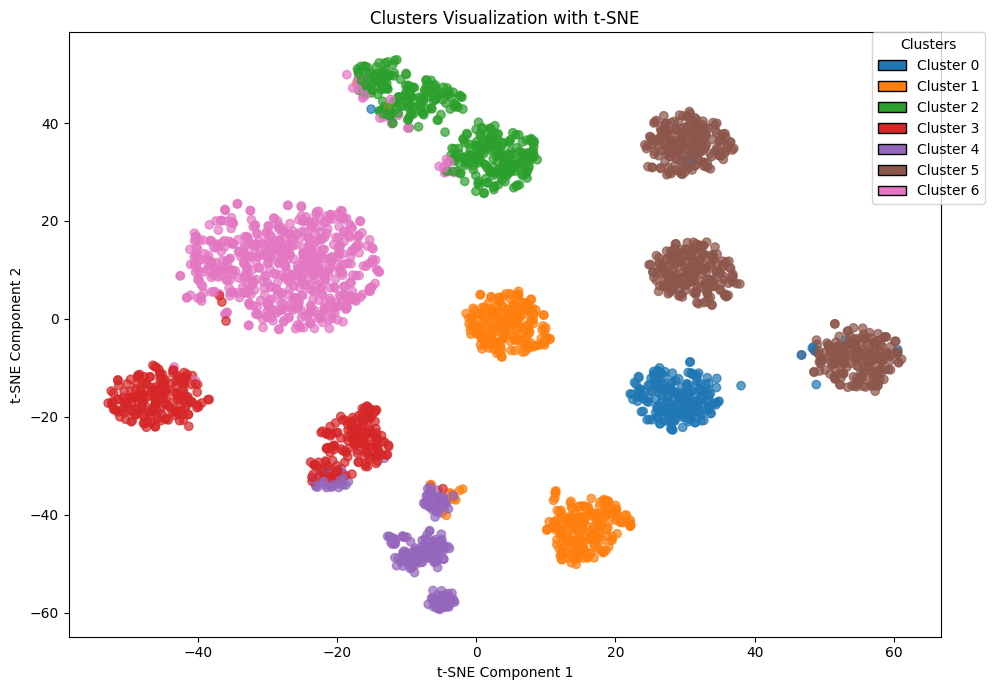

In [109]:
# Drop the 'emotion' column for clustering purposes
data = df.drop(columns=["filename", "emotion", "audio_data", "sr", "processed_audio"])

# Handle any missing values if necessary
data = data.fillna(0)

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_emotions, random_state=99)
kmeans.fit(data_scaled)

# Get the cluster labels
labels = kmeans.labels_

# Evaluate the clustering results using silhouette score
silhouette_avg = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Reduce the data to two dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=99)
data_tsne = tsne.fit_transform(data_scaled)

cmap = ListedColormap(plt.get_cmap("tab10").colors[:n_emotions])

# Create the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap=cmap, marker="o", alpha=0.7
)
plt.title("Clusters Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Create custom legend
# Generate a list of unique cluster labels
unique_labels = np.unique(labels)

# Create a list of Patch objects for the legend
legend_elements = [
    Patch(facecolor=cmap(i), edgecolor="k", label=f"Cluster {i}") for i in unique_labels
]

# Add the legend to the plot
plt.legend(
    handles=legend_elements,
    title="Clusters",
    loc="best",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()